# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Reading from the Kaggle's Alzheimer MRI 4 classes dataset

In [ ]:
X = []
y = np.array([])
labels = []

categories = ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented']

for i,stage in enumerate(categories):
    stage_path = '/content/drive/MyDrive/'+stage+'/'
    files = os.listdir(stage_path)
    for image in files:
        img = mpimg.imread(stage_path + image)
        #converts image into an array of pixels
        arr = np.array(img)
        y = np.append(y,i)
        X.append(arr)
        labels.append(stage)

In [ ]:
X = np.array(X)
df = pd.DataFrame(labels)
df.columns = ['AD Stage']

In [ ]:
X.shape

(5121, 208, 176)

In [ ]:
y.shape

(5121,)

In [ ]:
df

,AD Stage
0,NonDemented
1,NonDemented
2,NonDemented
3,NonDemented
4,NonDemented
...,...
5116,ModerateDemented
5117,ModerateDemented
5118,ModerateDemented
5119,ModerateDemented


# Data Visualization

In [ ]:
#count the number of images for each AD category
df.value_counts()

AD Stage        
NonDemented         2560
VeryMildDemented    1792
MildDemented         717
ModerateDemented      52
dtype: int64

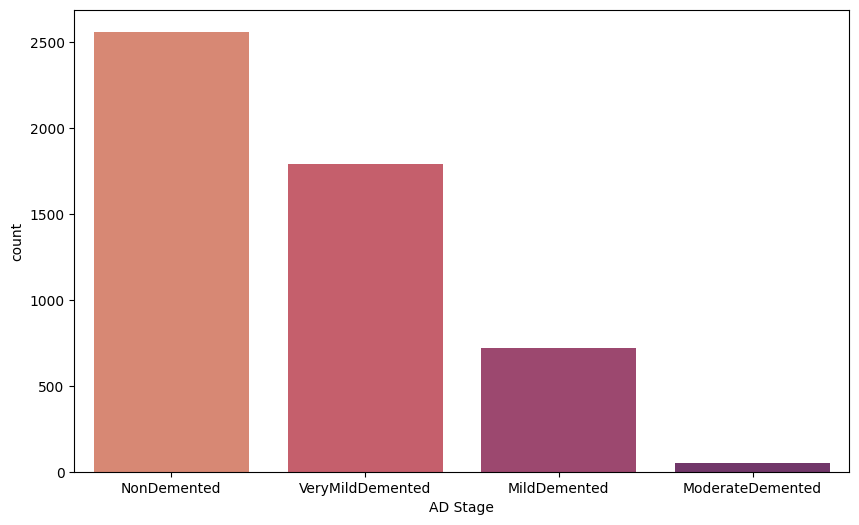

In [ ]:
#visualize the dataset
plt.figure(figsize=(10,6))
sns.countplot(x='AD Stage',data = df,palette = 'flare')
sns.set_style("whitegrid")

The dataset is highly imbalanced, so let's group all AD categories into a single one.

In [ ]:
#create a new column to label to group all AD categories
df['Condition']=df.apply(lambda x: 'AD' if x['AD Stage']!='NonDemented' else 'Healthy',axis=1)

In [ ]:
df

,AD Stage,Condition
0,NonDemented,Healthy
1,NonDemented,Healthy
2,NonDemented,Healthy
3,NonDemented,Healthy
4,NonDemented,Healthy
...,...,...
5116,ModerateDemented,AD
5117,ModerateDemented,AD
5118,ModerateDemented,AD
5119,ModerateDemented,AD


In [ ]:
#set all 'VeryMildDemented','MildDemented','ModerateDemented' images to 1 to indicate AD presence
y[y!=0]=1

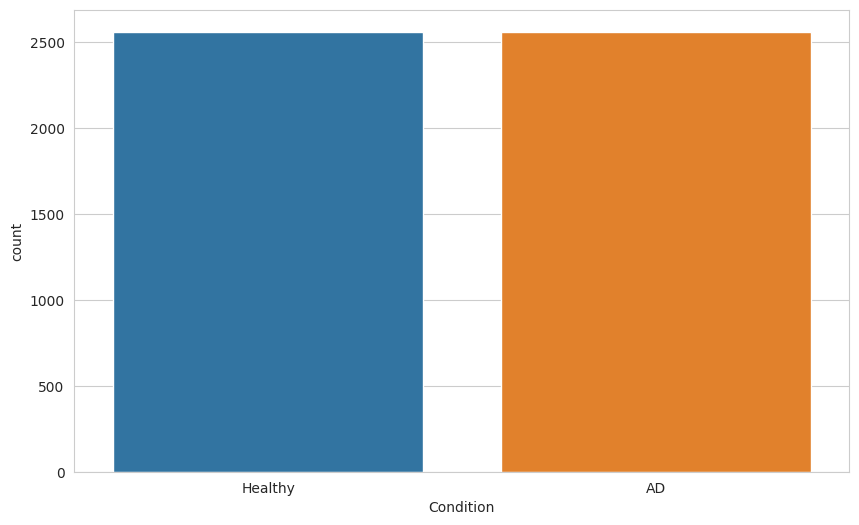

In [ ]:
#visualize the newly created AD category and the healthy controls
plt.figure(figsize=(10,6))
sns.countplot(x='Condition',data = df)
sns.set_style("whitegrid")

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# train test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [ ]:
# cast images into float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# normalize images
X_train /= 255
X_test /= 255

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Dropout
from tensorflow.keras.metrics import Accuracy

In [ ]:
# building the model
model = Sequential()

kernel = (3,3)
dropout_ratio = 0.3
# first convolutional layer
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu', input_shape=(208, 176,1)))
# second convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
# first maxpool layer
model.add(MaxPool2D(pool_size=(2,2)))
# adding dropout
model.add(Dropout(dropout_ratio))

# third convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
# second maxpool layer
model.add(MaxPool2D(pool_size=(2,2)))
# adding dropout
model.add(Dropout(dropout_ratio))

# fourth convolutional layer
model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
#maxpool layer
model.add(MaxPool2D(pool_size=(2,2)))
#adding dropout
model.add(Dropout(dropout_ratio))

# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(64, activation='relu'))
# adding dropout
model.add(Dropout(dropout_ratio))
# output layer
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 206, 174, 32)      320       
                                                                 
 conv2d_29 (Conv2D)          (None, 204, 172, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 102, 86, 64)      0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 102, 86, 64)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 100, 84, 64)       36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 50, 42, 64)       0         
 g2D)                                                 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#add and early stopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
#train the model
model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/50
128/128 [==============================] - 20s 137ms/step - loss: 0.7011 - accuracy: 0.5271 - val_loss: 0.6892 - val_accuracy: 0.6302
Epoch 2/50
128/128 [==============================] - 17s 134ms/step - loss: 0.5998 - accuracy: 0.6853 - val_loss: 0.5815 - val_accuracy: 0.6615
Epoch 3/50
128/128 [==============================] - 16s 128ms/step - loss: 0.5116 - accuracy: 0.7476 - val_loss: 0.4572 - val_accuracy: 0.7854
Epoch 4/50
128/128 [==============================] - 16s 129ms/step - loss: 0.4466 - accuracy: 0.7883 - val_loss: 0.4056 - val_accuracy: 0.8244
Epoch 5/50
128/128 [==============================] - 17s 132ms/step - loss: 0.3751 - accuracy: 0.8208 - val_loss: 0.3649 - val_accuracy: 0.8556
Epoch 6/50
128/128 [==============================] - 17s 132ms/step - loss: 0.3096 - accuracy: 0.8628 - val_loss: 0.3212 - val_accuracy: 0.8654
Epoch 7/50
128/128 [==============================] - 17s 133ms/step - loss: 0.2661 - accuracy: 0.8806 - val_loss: 0.2911 - val_ac

In [ ]:
#save the metrics history into a dataframe for visualization
met = pd.DataFrame(model.history.history)

<Axes: >

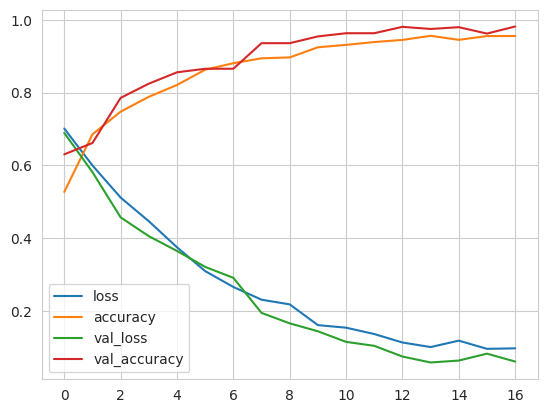

In [ ]:
#plot each metric
met.plot()

In [ ]:
print(model.metrics_names)
print(model.evaluate(X_test,y_test,verbose=0))

['loss', 'accuracy']
[0.06119305640459061, 0.9814634323120117]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

prob = model.predict(X_test)
prob = np.squeeze(prob)
predictions = np.array(prob>=0.5).astype(int)

33/33 [==============================] - 1s 23ms/step


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       515
         1.0       0.99      0.98      0.98       510

    accuracy                           0.98      1025
   macro avg       0.98      0.98      0.98      1025
weighted avg       0.98      0.98      0.98      1025



<Axes: >

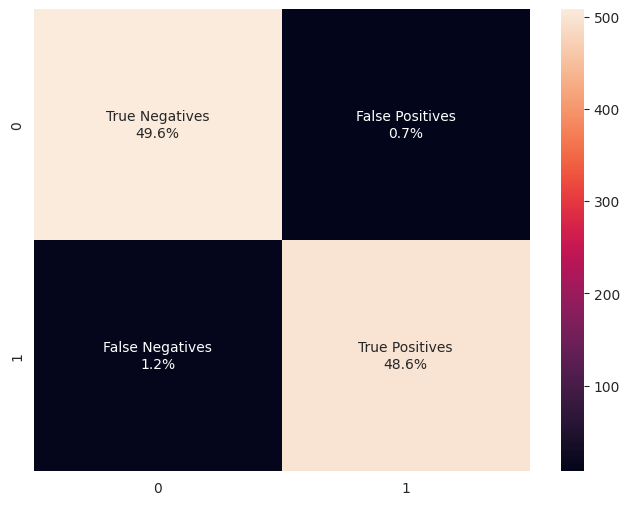

In [ ]:
#generate and plot confusion matrix
cf_matrix = confusion_matrix(y_test,predictions)

groups = ['True Negatives','False Positives','False Negatives','True Positives']

percentages = ['{0:.1%}'.format(x) for x in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{x}\n{y}' for x,y in
          zip(groups,percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='')


In [ ]:
#select random image
randimage = random.choice(range(X_test.shape[0]))
my_image = X_test[randimage,:,:,0]

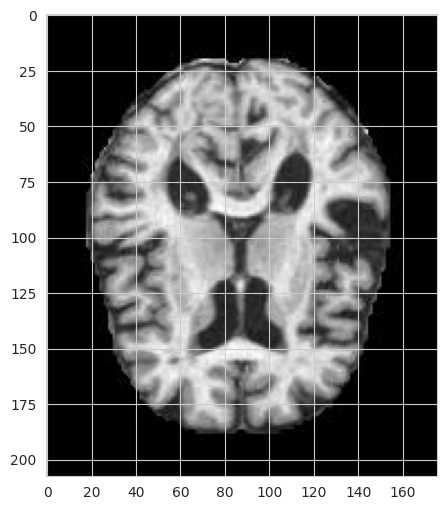

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(my_image,cmap='gray')
plt.show()

In [ ]:
#predict whether it correspond to an AD image or not
probimg = model.predict(my_image.reshape(1,208, 176, 1))
probimg = np.squeeze(probimg)
conditions = list(df['Condition'].unique())
pred = conditions[1 if probimg>0.5 else 0]
print(pred,'{0:.1%}'.format(probimg) )

1/1 [==============================] - 0s 27ms/step
AD 99.9%
